## Get Data

In [1]:
from sklearn.datasets import fetch_olivetti_faces

data = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\nolas\scikit_learn_data


Let's get to know the data by exploring the type and viewing some of the methods built in.

In [3]:
type(data)

sklearn.utils.Bunch

In [4]:
help(data)

Help on Bunch in module sklearn.utils object:

class Bunch(builtins.dict)
 |  Bunch(**kwargs)
 |  
 |  Container object exposing keys as attributes.
 |  
 |  Bunch objects are sometimes used as an output for functions and methods.
 |  They extend dictionaries by enabling values to be accessed by key,
 |  `bunch["value_key"]`, or by an attribute, `bunch.value_key`.
 |  
 |  Examples
 |  --------
 |  >>> from sklearn.utils import Bunch
 |  >>> b = Bunch(a=1, b=2)
 |  >>> b['b']
 |  2
 |  >>> b.b
 |  2
 |  >>> b.a = 3
 |  >>> b['a']
 |  3
 |  >>> b.c = 6
 |  >>> b['c']
 |  6
 |  
 |  Method resolution order:
 |      Bunch
 |      builtins.dict
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __dir__(self)
 |      Default dir() implementation.
 |  
 |  __getattr__(self, key)
 |  
 |  __init__(self, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __setattr__(self, key, value)
 |      Implement setattr(self, name, value).
 |  
 |  __se

In [5]:
data.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

In [7]:
data['data'].shape

(400, 4096)

In [8]:
data['target'].shape

(400,)

## Visualize 25 Faces

From the description of the assignment, we know that the images are flattened but are supposed to be 64 by 64. Let's visualize the first image, then 25 at once.

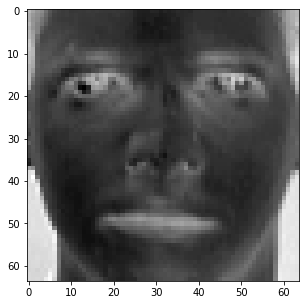

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

fig, axs = plt.subplots(1,1)
fig.set_size_inches(5,5)

sample = data['data'][0].reshape(64, 64)

plt.imshow(sample, cmap = mpl.cm.binary)
plt.show()

Now let's try to make a 5 by 5 grid of the first 25 faces.

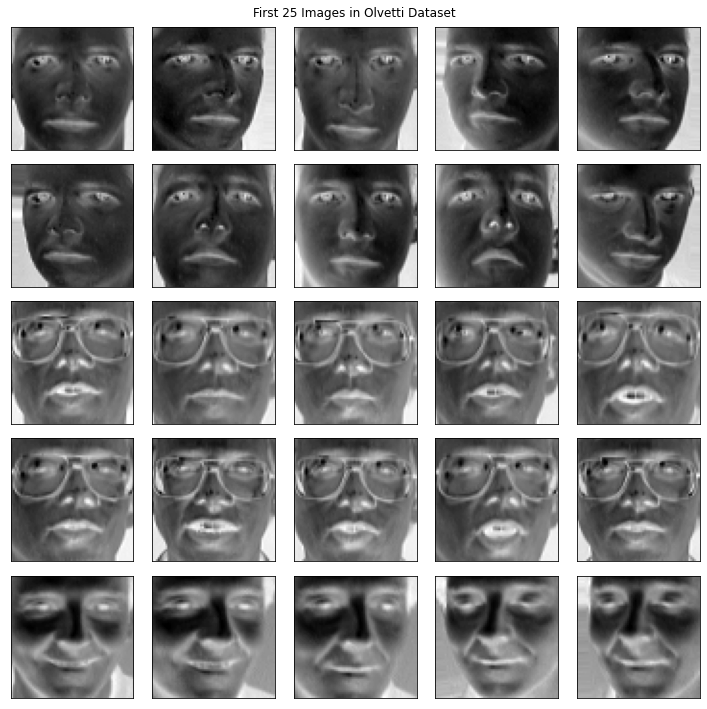

In [18]:
fig, axs = plt.subplots(5,5)

fig.set_size_inches(10,10)

axs = axs.ravel()
for ind in range(25):
    axs[ind].imshow(data['data'][ind].reshape(64,64), cmap = mpl.cm.binary)
    axs[ind].set_xticks([])
    axs[ind].set_yticks([])

fig.suptitle('First 25 Images in Olvetti Dataset')
fig.tight_layout()
plt.show()